# *Lecture 14*

# Discretization Methods

In previous lectures, the ordinary differential equation boundary value problems were solved numerically by converting the problem to an initial value problem.
Especially with the **shooting method**, the trick was to find the right *initial* value that satisfied the boundary conditions at the endpoints of the interval.
In all cases, we kept the differential equations themselves and used an ODE solver to evolve the system from the one end of the interval to the other (to a specific time $t$ or a specific point $x$).

For one-dimensional cases, the shooting method is almost always good enough to find a good solution.
The reason is that it is fairly straightforward to adjust the starting values to match a boundary condition at a single endpoint.
For higher-dimensional cases, the "endpoint" is not a single point, but rather a $N$-dimensional coordinate.  For example, a boundary condition in 2-D might need to be satisfied at the boundary of a circular area.  In that case, the boundary condition must be satisfied everywhere on the circle simultaneously.

Before we move on to discretization methods, let's follow up on the orbital mechanics introduction from last lecture.

# Orbital Mechanics Recap



All we need for orbital mechanics in the solar system is 
the force between
a body of mass $m$ and another body of mass $M$:

$$F^{(g)} = - \frac{G m M} { r^2}$$

where $r$ is the distance between objects, $G$ is the universal gravitational
constant, and the attractive force lies along the line between the two.

The equation of motion is still

$$\mathbf{F} = m \mathbf{a} = m \frac{d^2 \mathbf{x}}{dt^2}$$

with the force components given by

$$\begin{align}
F_x & = F^{(g)} \cos \theta = F^{(g)}\frac{x} { r} = F^{(g)}\frac{x} {
\sqrt{x^2+y^2}},\\ F_y & = F^{(g)} \sin \theta = F^{(g)}\frac{y} { r} =
F^{(g)}\frac{y} { \sqrt{x^2+y^2}}
\end{align}$$

The equation of motion can be rewritten as usual as two simultaneous second-order
ODE’s:

$$\frac{d^2 x}{dt^2} = -GM \frac{x}{r^3}, \quad \frac{d^2 y}{dt^2} = -GM \frac{y}{r^3}$$

The solution to these equations can be calculated with the following steps:

1. Calculate the units, for example, $GM = 1$, and define initial conditions

2.  Modify your ODE solver program to solve the first-order differential equations.

3.  Establish that you use small enough time steps so that the orbits
    are closed and fall upon themselves.

## Example: Moon Lander

We would like to send a lunar lander to the Moon.
We need to consider the gravitational forces on the lander from both Moon and Earth.

To simplify the problem a bit, we'll assume that the lunar lander does not affect the orbits of the Moon and Earth.
We'll also assume that their orbits are circular, and that they orbit a common-center-of-mass point.

If the distance between Earth and Moon is $d$, then the radii of the respective orbits are

$$\begin{align}
r_E &= \frac{m_M}{m_M + m_E} d \\
r_M &= \frac{m_E}{m_M + m_E} d
\end{align}$$

Since the two large bodies are exactly opposite each other on the orbit around the C.O.M. point, we can write the angle of their motion simply:

$$\begin{align}
\phi_M &= \omega t \\
\phi_E &= \omega t + \pi
\end{align}$$
with the frequency $\omega = 2\pi/T$.

The satellite feels the forces from both Earth and Moon, so that the differential equations of motions are

$$\begin{align}
\ddot{x} &= -G m_E \frac{x-x_E}{d_E^3} - G m_M \frac{x-x_M}{d_M^3} \\
\ddot{y} &= -G m_E \frac{y-y_E}{d_E^3} - G m_M \frac{y-y_M}{d_M^3} \\
\end{align}$$

We define a **state** of the satellite for our program
$S = (x, v_x, y, v_y)$, so that we can write a system of 4 first-order differential equations.

$$\begin{align}
\dot{x} &= v_x \\
\dot{v_x} &= -G m_E \frac{x-x_E}{d_E^3} - G m_M \frac{x-x_M}{d_M^3} \\
\dot{y} &= v_y \\
\dot{v_y} &= -G m_E \frac{y-y_E}{d_E^3} - G m_M \frac{y-y_M}{d_M^3} \\
\end{align}$$

<IPython.core.display.Javascript object>


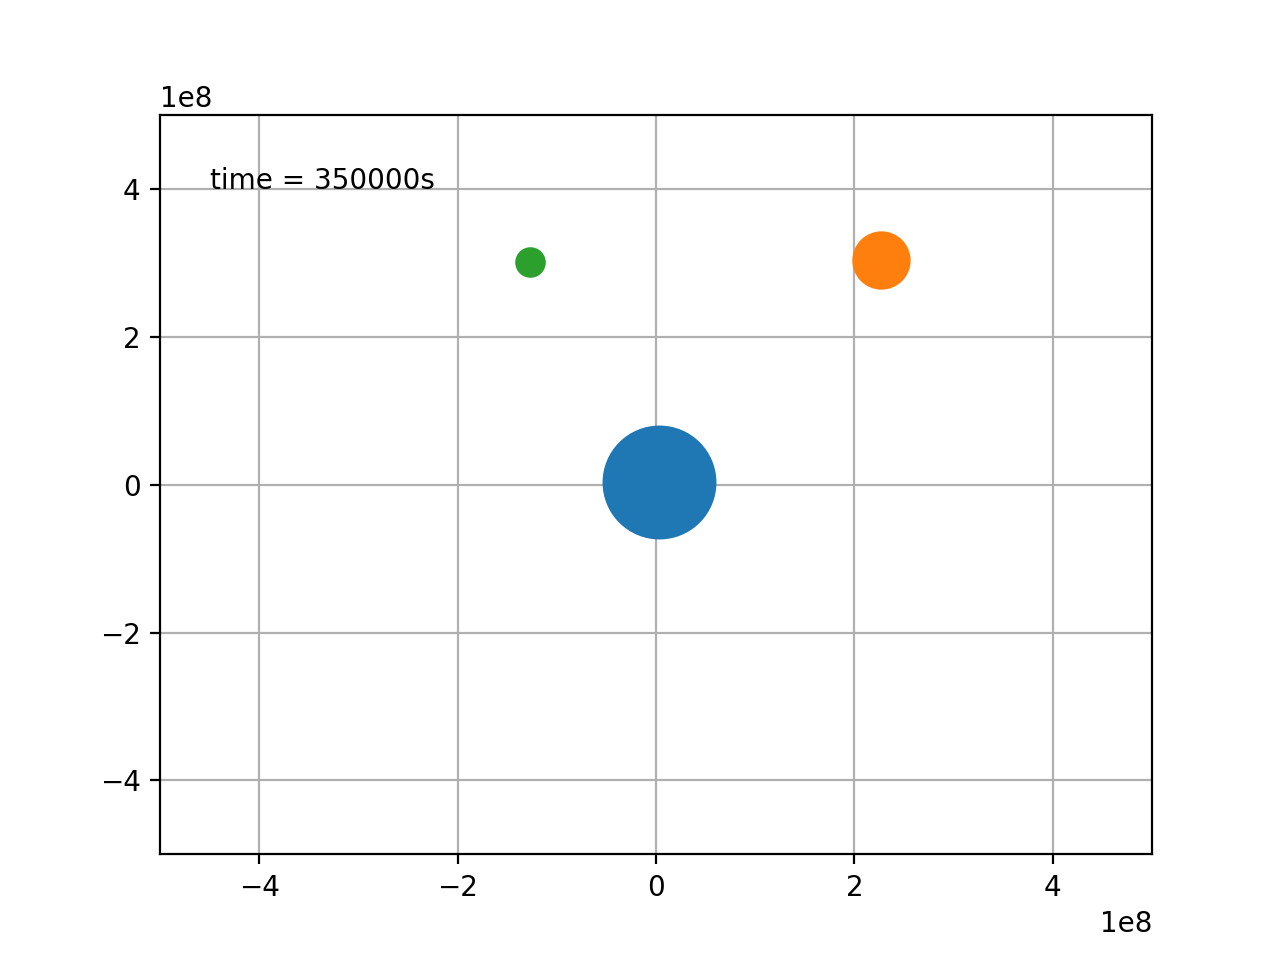

In [9]:
% matplotlib notebook

import numpy as np
import scipy.integrate as integrate
import matplotlib.animation as animation

d = 3.844e08 # meters
T = 27.322 * 24. * 3600. # seconds
omega = 2.*np.pi/T
m_earth = 5.976e24 # kilograms
m_moon = 7.35e22 # kilograms
#m_moon = 0
G = 6.67e-11 # N m^2 / kg

def moon_position(t):
    r_moon = m_earth / (m_moon + m_earth) * d
    phi_moon = omega * t
    x_moon = r_moon * np.cos(phi_moon)
    y_moon = r_moon * np.sin(phi_moon)
    return (x_moon, y_moon)
    
def earth_position(t):
    r_earth = m_moon / (m_moon + m_earth) * d
    phi_earth = omega*t + 2.*np.pi
    x_earth = r_earth * np.cos(phi_earth)
    y_earth = r_earth * np.sin(phi_earth)
    return (x_earth, y_earth)

def derivs(state, t):
    x = state[0]
    y = state[2]
    out = np.zeros_like(state)
    (x_E, y_E) = earth_position(t)
    (x_M, y_M) = moon_position(t)
    d_E = np.sqrt(pow(x-x_E, 2) + pow(y-y_E, 2))
    d_M = np.sqrt(pow(x-x_M, 2) + pow(y-y_M, 2))
    
    out[0] = state[1]
    out[1] = -G*m_earth*(x-x_E)/pow(d_E,3) - G*m_moon*(x-x_M)/pow(d_M,3)
    out[2] = state[3]
    out[3] = -G*m_earth*(y-y_E)/pow(d_E,3) - G*m_moon*(y-y_M)/pow(d_M,3)
    return out

# create a time array
dt = 50000 # seconds
time_interval = np.arange(0.0, 2*T, dt)
earth_positions = []
moon_positions = []

# state with 4 elements of satellite motion: (x, v_x, y, v_y)
state = (2e8, 0, 0, 1.5e3) # medium Earth orbit
state = (2e8, 0, 0, 1.7e3) # Moon landing at 3.5e6 s (40 days)

satellite_positions = integrate.odeint(derivs, state, time_interval)

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-5e8, 5e8), ylim=(-5e8, 5e8))
ax.grid()

earth_marker, = ax.plot([], [], 'o-', markersize=40)
moon_marker, = ax.plot([], [], 'o-', markersize=20)
satellite_marker, = ax.plot([], [], 'o-', markersize=10)
time_template = 'time = %.0fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

itime = 0
for time in time_interval:
    earth_positions.append(earth_position(time))
    moon_positions.append(moon_position(time))

def init():
    earth_marker.set_data([], [])
    moon_marker.set_data([], [])
    satellite_marker.set_data([], [])
    time_text.set_text('')
    return earth_marker, moon_marker, time_text

def animate(i):
    earth_marker.set_data(earth_positions[i][0], earth_positions[i][1])
    moon_marker.set_data(  moon_positions[i][0],  moon_positions[i][1])
    satellite_marker.set_data(satellite_positions[i,0], satellite_positions[i,2])
    time_text.set_text(time_template % (i*dt))
    return earth_marker, moon_marker, time_text

ani = matplotlib.animation.FuncAnimation(fig, animate, np.arange(1, len(time_interval)),
                                         interval=200, blit=True, init_func=init)

# Approaches to Solving ODE

The methods we have been studying require evaluation of the first-order derivatives, so that we know how far to step with our solution at each time step.
This is fine if the derivatives are known.  (They must be, since they are the differential equation!)

Those methods give use **the answer** for each time step, and that answer is never revisited in subsequent steps.
If there is a problem with any single step, so that we get an inaccurate answer, there will be a cumulative build-up of error for all of the subsequent steps.

Now we will look at two new methods for solving ODEs.  These methods use a discrete *finite* set of points or intervals at which the differential equations are solved:
* **finite difference method**: choose a set of points at which to approximate the derivatives with finite differences
* **finite element method**: choose a trial function and adjust parameters to minimize the integrated error over a set of intervals (elements)


# Finite Difference Method

The finite difference method replaces the analytic or functional derivative by a difference.
In this way, the *differential equation* is replaced by a *difference equation*.
This method works best if the the derivative is a linear function $f(t, x, x')$.

As an example, let's consider the differential equation in 1 dimension $y$, with $x$ as the independent variable.
(Sometimes it is good to remember that these methods can work with space intervals as well as time intervals.)

$$\begin{cases}
\frac{d^2 y}{dx^2} = 5 \frac{dy}{dx} - 10 y(x) + 10x \\
y(0) = 0 \\
y(1) = 100
\end{cases}$$

In order to write some finite difference (usually central-difference) substitutions for the derivatives, we need to define a discrete "grid" of points.
Here, a convenient grid might be 11 points $(0.0, 0.1, \dots 0.9, 1.0)$.
Our new goal will be to find $y_i$ values ($i=1,\dots,9$) for the 9 points inside the interval.
The $y$ values on the endpoints ($y_0, y_{10}$) are of course fixed by the boundary conditions.

The first step is to approximate the first and second derivatives by the appropriate central-difference and midpoint formulas:

$$\begin{align}
y_i'(x) &\approx \frac{y_{i+1}-y_{i-1}}{2h} \\
y_i''(x) &\approx \frac{y_{i+1} - 2y_i + y_{i-1}}{h^2}
\end{align}$$

Note that the step $h$ is between the discrete grid (mesh) points.  This step may be a step in time or a step along the spatial dimensions.

The second step is to substitute these approximations in the original differential equation to convert it to a finite difference equation:

$$\frac{y_{i+1} - 2y_i + y_{i-1}}{h^2} = 5 \frac{y_{i+1}-y_{i-1}}{2h} - 10 y_i + 10 x_i$$

Now we can solve for $y_i$.  (But remember that we have made approximations in defining a discrete grid and converting the derivatives.)

$$y_i = \frac{1}{2- 10h^2} \left[ \left( 1- \frac{5h}{2} \right) y_{i+1} + \left( 1+ \frac{5h}{2} \right) y_{i-1} - 10h^2 x_i \right]$$

We saw forms like this in our explorations of explicit and implicit methods for ODEs.
It should be possible to write the equations in linear algebra form (9 equations for 9 unknowns) and solve for $y_i$.
This particular equation is like the implicit methods because $y_i$ relies on knowledge of $y_{i+1}$.

In practice, these $N-2$ approximate difference equations are solved through an **iterative** process, in which the $y_i$ values are updated on successive passes through the grid.
The idea is that an estimate of $y_i^{(j)}$ on the $j$th iteration through the grid will be updated to $y_i^{(j+1)}$.

$$y_i^{(j)} = \frac{1}{2- 10h^2} \left[ \left( 1- \frac{5h}{2} \right) y_{i+1}^{(j-1)} + \left( 1+ \frac{5h}{2} \right) y_{i-1}^{(j-1)} - 10h^2 x_i \right]$$

Of course, we cannot use the new values of $y_{i+1}^{(j-1)}$ and $y_{i-1}^{(j-1)}$ until we have calculated them!

But if we move from "left to right" ("top to bottom") in the equations for $y_i$, we will know $y_{i-1}^{(j)}$ in time to use it in calculating $y_i^{(j)}$.
This approach of using the updated values as soon as they become available is known as the **Gauss-Seidel** iteration procedure.

* **Jacobi method**: use only the values from the previous iteration.  Pro: calculation of each $y_i$ can proceed in parallel. Con: requires two state vectors `old` and `new` to hold $y_i$ values.
* **Gauss-Seidel method**: use the values from the current iteration when available.  Pro: requires only one state vector, with $y_i$ updated in place.  Con: cannot be parallelized.

When the difference between successive iterations is small enough (compared to some tolerance), we stop the process.
We cannot stop the process unless the difference is acceptable for **all** $y_i$ values!


In [5]:
# Jacobi method

N = 11
(x_grid_points, h) = linspace(0., 1., 11, retstep=True)
c1 = 1.0 - 2.5*h
c2 = 1.0 + 2.5*h
c3 = -10.0 * pow(h,2)
c4 = 2.0 + c3

old_y_values = np.zeros(N)
old_y_values[0] = 0.
old_y_values[N-1] = 100.
y_values = old_y_values.copy()

tolerance = 0.0001
achieved_tolerance = False
iteration = 0
while (not achieved_tolerance):
    iteration += 1
    achieved_tolerance = True   # until we know otherwise
    for i in range(1,N-1):
        yy = 1./c4 * (c1*old_y_values[i+1] + c2*old_y_values[i-1] + c3*x_grid_points[i])
        if (abs((yy-y_values[i]))/yy > tolerance):
            achieved_tolerance = False
            print('Iteration', iteration, ': Not at tolerance for i =', i)
        y_values[i] = yy
        old_y_values[i] = yy
        
    print(y_values)


Iteration 1 : Not at tolerance for i = 9
[ 0.00000000e+00 -5.26315789e-03 -1.39889197e-02 -2.49927103e-02
 -3.74952041e-02 -5.09836869e-02 -6.51208467e-02 -7.96847675e-02
 -9.45294523e-02  3.93641254e+01  1.00000000e+02]
Iteration 2 : Not at tolerance for i = 8
Iteration 2 : Not at tolerance for i = 9
[ 0.00000000e+00 -1.07850999e-02 -2.74873198e-02 -4.86739752e-02
 -7.32001232e-02 -1.00179363e-01 -1.28940936e-01 -1.58985926e-01
  1.53917693e+01  4.95524798e+01  1.00000000e+02]
Iteration 3 : Not at tolerance for i = 7
Iteration 3 : Not at tolerance for i = 8
Iteration 3 : Not at tolerance for i = 9
[ 0.00000000e+00 -1.61134157e-02 -4.03406584e-02 -7.12241660e-02
 -1.07455121e-01 -1.47907686e-01 -1.91644238e-01  5.91277456e+00
  2.34080674e+01  5.48263601e+01  1.00000000e+02]
Iteration 4 : Not at tolerance for i = 6
Iteration 4 : Not at tolerance for i = 7
Iteration 4 : Not at tolerance for i = 8
Iteration 4 : Not at tolerance for i = 9
[ 0.00000000e+00 -2.11871020e-02 -5.25800011e-02 -

Iteration 42 : Not at tolerance for i = 7
Iteration 42 : Not at tolerance for i = 8
Iteration 42 : Not at tolerance for i = 9
[  0.           1.67603757   4.30427303   8.21489899  13.79125557
  21.44963906  31.59879673  44.57086804  60.51426684  79.23833345
 100.        ]
Iteration 43 : Not at tolerance for i = 1
Iteration 43 : Not at tolerance for i = 2
Iteration 43 : Not at tolerance for i = 3
Iteration 43 : Not at tolerance for i = 4
Iteration 43 : Not at tolerance for i = 5
Iteration 43 : Not at tolerance for i = 6
Iteration 43 : Not at tolerance for i = 7
Iteration 43 : Not at tolerance for i = 8
Iteration 43 : Not at tolerance for i = 9
[  0.           1.69379198   4.3465338    8.28768891  13.89833707
  21.59053626  31.76648492  44.74937173  60.67656039  79.34510552
 100.        ]
Iteration 44 : Not at tolerance for i = 1
Iteration 44 : Not at tolerance for i = 2
Iteration 44 : Not at tolerance for i = 3
Iteration 44 : Not at tolerance for i = 4
Iteration 44 : Not at tolerance fo

Iteration 69 : Not at tolerance for i = 7
Iteration 69 : Not at tolerance for i = 8
Iteration 69 : Not at tolerance for i = 9
[  0.           1.91528776   4.87375741   9.19577472  15.23422066
  23.34827884  33.8584504   46.97626129  62.70122226  80.67711991
 100.        ]
Iteration 70 : Not at tolerance for i = 1
Iteration 70 : Not at tolerance for i = 2
Iteration 70 : Not at tolerance for i = 3
Iteration 70 : Not at tolerance for i = 4
Iteration 70 : Not at tolerance for i = 5
Iteration 70 : Not at tolerance for i = 6
Iteration 70 : Not at tolerance for i = 7
Iteration 70 : Not at tolerance for i = 8
Iteration 70 : Not at tolerance for i = 9
[  0.           1.91858845   4.881614     9.20930684  15.25412772
  23.37447235  33.88962442  47.00944591  62.73139332  80.69696929
 100.        ]
Iteration 71 : Not at tolerance for i = 1
Iteration 71 : Not at tolerance for i = 2
Iteration 71 : Not at tolerance for i = 3
Iteration 71 : Not at tolerance for i = 4
Iteration 71 : Not at tolerance fo

Iteration 98 : Not at tolerance for i = 3
Iteration 98 : Not at tolerance for i = 4
Iteration 98 : Not at tolerance for i = 5
Iteration 98 : Not at tolerance for i = 6
Iteration 98 : Not at tolerance for i = 7
[  0.           1.96095593   4.9824607    9.38300426  15.50965354
  23.71069053  34.28977205  47.43540148  63.11866709  80.95175466
 100.        ]
Iteration 99 : Not at tolerance for i = 1
Iteration 99 : Not at tolerance for i = 2
Iteration 99 : Not at tolerance for i = 3
Iteration 99 : Not at tolerance for i = 4
Iteration 99 : Not at tolerance for i = 5
Iteration 99 : Not at tolerance for i = 6
Iteration 99 : Not at tolerance for i = 7
[  0.           1.96149764   4.98375013   9.38522517  15.51292071
  23.71498944  34.29488837  47.44084778  63.1236188   80.95501237
 100.        ]
Iteration 100 : Not at tolerance for i = 1
Iteration 100 : Not at tolerance for i = 2
Iteration 100 : Not at tolerance for i = 3
Iteration 100 : Not at tolerance for i = 4
Iteration 100 : Not at toleran

## Successive Over-Relaxation (SOR)

We hope that each iteration will bring us closer to the stable correct solution for the discrete grid.
The system is **relaxing** to its stable state.
The rate of relaxation to the stable value depends on the coefficients of the differential equation itself.

We can push the relaxation to happen faster by replacing the $y_i$ values from the iteration with our own guesses.
The key is to exaggerate the difference with respect to the previous iteration, in hopes of reaching a stable point faster.
Instead of just taking 

$$y_i^{(j)} = \frac{1}{2- 10h^2} \left[ \left( 1- \frac{5h}{2} \right) y_{i+1}^{(j-1)} + \left( 1+ \frac{5h}{2} \right) y_{i-1}^{(j)} - 10h^2 x_i \right]$$

we substitute in our own guess $\bar{y}_i^{(j)}$:

$$\bar{y}_i^{(j)} = y_i^{(j)} + \alpha \left[ y_i^{(j)} - y_i^{(j-1)} \right]$$

This is called **over-relaxation**.  Useful values of $\alpha$ are between 0 and 1 (but be careful with different definitions of $\alpha$).
Of course, if $\alpha=0$, we recover our usual method.
If $\alpha=1$, we are doubling our iterative change in $y_i$, which is aggressive.
As the change in $y_i$ goes to zero, the correction from SOR also goes smoothly to zero.

In [8]:
# Implement SOR with Jacobi method

# Jacobi method

N = 11
(x_grid_points, h) = linspace(0., 1., 11, retstep=True)
c1 = 1.0 - 2.5*h
c2 = 1.0 + 2.5*h
c3 = -10.0 * pow(h,2)
c4 = 2.0 + c3

old_y_values = np.zeros(N)
old_y_values[0] = 0.
old_y_values[N-1] = 100.
y_values = old_y_values.copy()

alpha = 0.5
tolerance = 0.001
achieved_tolerance = False
iteration = 0
while (not achieved_tolerance):
    iteration += 1
    achieved_tolerance = True   # until we know otherwise
    for i in range(1,N-1):
        yy = 1./c4 * (c1*old_y_values[i+1] + c2*y_values[i-1] + c3*x_grid_points[i])
        if (abs((yy-old_y_values[i]))/yy > tolerance):
            achieved_tolerance = False
            print('Iteration', iteration, ': Not at tolerance for i =', i)
        y_values[i] = yy + alpha*(yy-old_y_values[i])
        old_y_values[i] = y_values[i]
        
    print(y_values)



Iteration 1 : Not at tolerance for i = 9
[ 0.00000000e+00 -7.89473684e-03 -2.35803324e-02 -4.69542754e-02
 -7.79154034e-02 -1.16363885e-01 -1.62201202e-01 -2.15330134e-01
 -2.75654737e-01  5.88674460e+01  1.00000000e+02]
Iteration 2 : Not at tolerance for i = 8
Iteration 2 : Not at tolerance for i = 9
[ 0.00000000e+00 -1.79094073e-02 -4.94749383e-02 -9.51651455e-02
 -1.55433887e-01 -2.30720631e-01 -3.21450759e-01 -4.28035856e-01
  3.45079903e+01  6.37596885e+01  1.00000000e+02]
Iteration 3 : Not at tolerance for i = 7
Iteration 3 : Not at tolerance for i = 8
Iteration 3 : Not at tolerance for i = 9
[ 0.00000000e+00 -2.82344045e-02 -7.52626873e-02 -1.42407249e-01
 -2.31006374e-01 -3.42412871e-01 -4.77992763e-01  2.01194140e+01
  4.02899790e+01  6.70194771e+01  1.00000000e+02]
Iteration 4 : Not at tolerance for i = 6
Iteration 4 : Not at tolerance for i = 7
Iteration 4 : Not at tolerance for i = 8
Iteration 4 : Not at tolerance for i = 9
[ 0.00000000e+00 -3.83409678e-02 -1.00314693e-01 -

Try some different values of $\alpha$ and notice how the required number of iterations changes.
Make sure you try $\alpha=0,0.5,1.0$ for comparisons.

## Linear Algebra Form

You may have noticed that the equation 

$$\frac{d^2 y}{dx^2} = 5 \frac{dy}{dx} - 10 y(x) + 10x$$

gives formulae for $y_i$ with recognizable coefficients:

$$y_i = \frac{1}{2- 10h^2} \left[ \left( 1- \frac{5h}{2} \right) y_{i+1} + \left( 1+ \frac{5h}{2} \right) y_{i-1} - 10h^2 x_i \right]$$

There are $N-2$ equations for the $N-2$ unknown $y_i$, so the system of equations will be a square matrix of order $N-2$.
To make things cleaner, let's write some generic coefficients.

Assume some generic coefficients $(u,v,w)$:
$$\begin{align}
f(x,y,y') &= u(x) + v(x) y + w(x) y' \\
y_0 &= \alpha \\
y_N &= \beta 
\end{align}$$

The difference equation looks like

$$\frac{1}{h^2} \left( y_{i-1} - 2 y_i + y_{i+1} \right) = u(x_i) + v(x_i) y_i  + w(x_i) \left[ \frac{1}{2h} \left( x_{i+1} - x_{i-1} \right) \right]$$

After gathering terms by $y_i$, we have a more organized difference equation

$$-\left( 1 + \frac{h}{2} w_i \right) y_{i-1} + (2+h^2 v_i) y_i + \left( 1 - \frac{h}{2} w_i \right) y_{i+1} = -h^2 u_i$$

Now you can see the recognizable coefficients again.

$$\begin{cases}
a_i &=  -\left( 1 + \frac{h}{2} w_i \right) \\
d_i &= 2 + h^2 v_i \\
c_i &= - \left( 1 - \frac{h}{2} w_i \right) \\
b_i &= -h^2 u_i
\end{cases}$$

With these coefficients, the main difference equation (the "more organized" one) assumes an obviously linear form:

$$a_i y_{i-1} + d_i y_i + c_i x_{i+1} = b_i$$

The $i=1$ and $i=N-1$ equations are special, because they are next to the boundaries, with boundary condition values $\alpha$ and $\beta$:

$$\begin{cases}
 & & d_1 y_1 & + & c_1 y_2 &=  b_1 - a_1 \alpha \\
a_i y_{i-1} & + & d_i y_i & + & c_i y_{i+1} &= b_i \\
a_{N-1} y_{N-2} & + & d_{N-1} y_{N-1} & & &= b_{N-1} - c_{N-1} \beta
\end{cases}$$

We don't even write the $i=0$ and $i=N$ equations; they are the boundary conditions!

Now we can finally write this system in matrix form.  From here we can use any sort of linear algebra solver to find the $y_i$ values.

$$\begin{bmatrix}
d_1 & c_1 & & & & \\
a_2 & d_2 & c_2 & & & \\
 & a_3 & d_3 & c_3 & & \\
 & & \ddots & \ddots & \ddots & \\
 & & & a_{n-2} & d_{n-2} & c_{n-2} \\
 & & & & a_{n-1} & d_{n-1} \\
\end{bmatrix}
\begin{bmatrix}
y_1 \\
y_2 \\
y_3 \\
\dots \\
y_{n-2} \\
y_{n-1}
\end{bmatrix}
=
\begin{bmatrix}
b_1 & - a_1 \alpha \\
b_2 & \\
b_3 & \\
\vdots \\
b_{n-2} & \\
b_{n-1} & - c_{n-1} \beta
\end{bmatrix}
$$

This is a tridiagonal matrix, and it can be solved with Gaussian elimination methods.

Note that this is **not an iterative method**!
It gives the exact solution to the system of equations.
(Of course, these difference equations are themselves approximations to the differential equation.)

# Finite Element Method

The other discretization method is the **finite element** method.
In this method, we adopt a trial function that it supposed to approximate the exact solution, and we solve constraint equations for the parameters of the trial function.
(You might think of this as being similar to the variational method, in the sense of a trial solution.)

The constraint equations are designed to minimize the total residual error between the exact derivative $y''$ and the second derivative of the trial function.
By total residual error, we mean the **integrated** residual error (probably the residual error squared) over all of the discrete intervals.

Let's look at a simple example:

$$\begin{align}
y'' - 6x &= 0 \\
y(0) &= 0\\
y(1) &= 1
\end{align}$$

A guess for the trial function might look like

$$p(x) = \alpha x^2 + \beta x + \gamma$$

The boundary conditions require $\gamma=0$ and $\beta = 1-\alpha$.

The residual error in this case is 

$$\begin{align}
R &= p'' - y''\\
&= 2\alpha - 6x \\
\end{align}$$

To find the best value of $\alpha$, we need to calculate

$$I = \int_0^1 R^2 \, dx$$

over our discrete mesh (set of intervals), and find the value of $\alpha$ that minimizes the total error $I$.

The main advantage of the **finite element** method over the **finite difference** method is that the finite element method is less strict point-to-point convergence, and more sensitive to overall agreement.
This is very similar to the relationship between the least-squares method and the Lagrange interpolating polynomial.

A common way to implement the finite element method is to place a little trial function with limited local support on each interval.  (A triangular basis function centered at $x_i$ is a convenient option.)
This choice of individual local trial functions guarantees a piecewise linear approximation of the overall trial function.